In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy

In [3]:
### specify which msa sequences to train the model on
START_IDX = 0
END_IDX = 10000
FILE_SUFFIX = (str(START_IDX)+'_'+ str(END_IDX)) if START_IDX != 0 else str(END_IDX)

In [4]:
fasta_sequences = SeqIO.parse(open("BLAT_ECOLX/data/BLAT_ECOLX.a2m"),'fasta')
with open(f"BLAT_ECOLX/data/BLAT_ECOLX_{FILE_SUFFIX}.a2m", "w+") as out_file:
    cnt = 0
    seq = []
    for fasta in fasta_sequences:
        if cnt >= END_IDX:
            break
        if START_IDX <= cnt:
            seq.append(fasta)
        cnt += 1

    SeqIO.write(seq, out_file, "fasta")

In [5]:
regularization = 0.01 * 20 * (214)
print(regularization)

42.800000000000004


In [9]:
### training code for model
!plmc/bin/plmc -o BLAT_ECOLX/model/BLAT_ECOLX_{FILE_SUFFIX}.model_params -c BLAT_ECOLX/model/BLAT_ECOLX_{FILE_SUFFIX}.txt -f BLAT_ECOLX -le 42.8 -lh 0.01 -m 200 -t 0.2 -g BLAT_ECOLX/data/BLAT_ECOLX_{FILE_SUFFIX}.a2m

Found focus BLAT_ECOLX as sequence 1
9935 valid sequences out of 10000 
215 sites out of 286
Region starts at 1
Effective number of samples (to 1 decimal place): 1799.5	(80% identical neighborhood = 1.000 samples)
iter	time	cond	fx	-loglk	||h||	||e||
1	0.9	387.93	600995.6	600802.6	122.5	1.0
2	1.3	185.20	529256.9	528658.3	122.5	3.2
3	1.8	128.18	485834.4	484350.8	122.5	5.6
4	2.4	200.21	441469.3	436381.4	122.5	10.7
5	2.9	162.04	415279.9	403581.2	122.5	16.4
6	3.5	105.68	400775.5	387166.6	122.4	17.7
7	4.1	126.12	387178.0	369813.2	122.4	20.1
8	4.6	105.90	375213.3	353873.6	122.4	22.3
9	5.2	112.02	357518.6	325136.5	122.3	27.4
10	5.8	111.30	347003.5	306361.7	122.3	30.8
11	6.3	76.26	338887.5	298732.8	122.3	30.6
12	6.9	68.21	328643.0	288111.3	122.3	30.7
13	7.5	76.97	321360.4	277485.7	122.3	32.0
14	8.0	66.33	314354.2	264099.8	122.3	34.2
15	8.6	48.12	308381.0	251879.0	122.3	36.3
16	9.2	48.26	303796.6	239571.0	122.3	38.7
17	9.7	51.10	300827.8	230334.6	122.3	40.5
18	10.3	33.45	298313.0	225343.8	122.3

In [6]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True
    
def model_info(c):
    print("Number of sites: ", c.L)
    print("Number of invalid sequences: ", c.N_invalid)
    print("Number of valid sequences: ", c.N_valid)

def mutant_predictions(c):
    # read the experimental mutational scanning dataset for PABP by Melamed et al., RNA, 2013
    data = pd.read_csv(
        "BLAT_ECOLX/data/BLAT_ECOLX.csv", sep=";", comment="#"
    )

    # predict mutations using our model
    data_pred = tools.predict_mutation_table(
        c, data, "effect_prediction_epistatic"
    )

    # can also add predictions by the corresponding independent model
    c0 = c.to_independent_model()

    data_pred = tools.predict_mutation_table(
        c0, data_pred, "effect_prediction_independent"
    )
    
    print(data_pred.head())
    pred = data_pred['effect_prediction_epistatic']
    pred_ind = data_pred['effect_prediction_independent']
    label = data_pred['linear']
    print('Evmutation spearman: ', scipy.stats.spearmanr(pred, label))
    print('Independent control spearman: ', scipy.stats.spearmanr(pred_ind, label))

def get_mutant_seq(wildtype, pos_upper):
    data = pd.read_csv(
        "BLAT_ECOLX/data/BLAT_ECOLX.csv", sep=";", comment="#"
    )
    mutant, label = data['mutant'].to_numpy(), data['linear'].to_numpy()
    mutant_data = []
    for m in mutant:
        if m == 'wild':
            mutant_data.append(np.asarray(list(wildtype))[pos_upper])
            continue
        original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
        assert wildtype[loc] == original_aa
        mut_seq = np.asarray(list(wildtype[:loc]+mutant_aa+wildtype[loc+1:]))
        mutant_data.append(mut_seq[pos_upper])
    mutant_data = np.asarray(mutant_data)
    return mutant_data, label

# modify energy computation to enable computing sequences with gap characters
def mod_convert_sequences(sequences, c):

    L_seq = sequences.shape[1]
    S = np.empty((sequences.shape[0], L_seq), dtype=int)

    try:
        for i, s in enumerate(sequences):
            conv = []
            for x in s:
                if x == '-':
                    conv.append(-1)
                else:
                    conv.append(c.alphabet_map[x])
            S[i] = conv
    except KeyError:
        raise ValueError("Invalid symbol in sequence {}: {}".format(i, x))
    return S
    
def mod_hamiltonians(sequences, J_ij, h_i):
    """
    Calculates the Hamiltonian of the global probability distribution P(A_1, ..., A_L)
    for a given sequence A_1,...,A_L from J_ij and h_i parameters

    Parameters
    ----------
    sequences : np.array
        Sequence matrix for which Hamiltonians will be computed
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size len(sequences) x 3, where each row corresponds to the
        1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
    """
    # iterate over sequences
    N, L = sequences.shape
    H = np.zeros((N, 3))
    for s in range(N):
        A = sequences[s]
        hi_sum = 0.0
        Jij_sum = 0.0
        for i in range(L):
            if A[i] != -1:
                hi_sum += h_i[i, A[i]]
                for j in range(i + 1, L):
                    if A[j] != -1:
                        Jij_sum += J_ij[i, j, A[i], A[j]]

        H[s] = [Jij_sum + hi_sum, Jij_sum, hi_sum]

    return H

def energies_from_model(c, sequences):
    S = mod_convert_sequences(sequences, c)
    msa_energies = mod_hamiltonians(S, c.J_ij, c.h_i)
    return msa_energies

def valid_weights_from_model(c):
    ### returns only valid weights
    _w = c.weights
    _w_valid = []
    _valid_indices = []
    for i in range(c.weights.shape[0]):
        if _w[i] == 0: 
            continue
        _w_valid.append(1/_w[i])
        _valid_indices.append(i)
    return _w_valid, _valid_indices

def valid_index(c, idx):
    _w = c.weights
    cnt = 0
    assert idx <=_w.shape[0]
    for i in range(idx):
        if _w[i] == 0:
            cnt += 1
    return idx - cnt

In [7]:
c = CouplingsModel(f"BLAT_ECOLX/model/BLAT_ECOLX.model_params")
model_info(c)
w_full_valid, valid_indices = valid_weights_from_model(c)

Number of sites:  215
Number of invalid sequences:  721
Number of valid sequences:  208923


In [8]:
### Getting the raw string representations of the sequences
### sequence can be invalid for two reasons: 
### 1. Does not pass check_sequence()
### 2. contains 'x'

ecolx_seq_str = []
fasta_sequences = SeqIO.parse(open("BLAT_ECOLX/data/BLAT_ECOLX.a2m"),'fasta')
for fasta in fasta_sequences:
    ecolx_seq_str.append(str(fasta.seq))
ecolx_seq_str = np.asarray(ecolx_seq_str)
pos_upper = [x for x in range(len(ecolx_seq_str[0])) if not ecolx_seq_str[0][x].islower()]
processed_ecolx = np.asarray([np.asarray(list(s))[pos_upper] for s in ecolx_seq_str[valid_indices]])
# processed_ecolx = np.asarray([s for s in processed_ecolx if check_sequence(s) and len(s)==len(pos_upper)])
wildtype = ecolx_seq_str[0]
print(processed_ecolx.shape)

(208923, 215)


In [11]:
### compute energies obtained from model trained with all sequences
msa_energies = energies_from_model(c, processed_ecolx)

(array([1.00000000e+00, 0.00000000e+00, 3.00000000e+00, 1.33333333e+00,
        1.00000000e+00, 1.40000000e+01, 5.35606061e+00, 1.29772727e+01,
        2.81178161e+01, 3.52363101e+01, 4.32252079e+01, 6.25423720e+01,
        1.01537614e+02, 1.07786408e+02, 1.56195535e+02, 2.29527252e+02,
        3.08756193e+02, 3.86761538e+02, 4.38320525e+02, 5.44556796e+02,
        6.32572324e+02, 7.29743232e+02, 8.62808760e+02, 1.03065232e+03,
        1.13423735e+03, 1.31049794e+03, 1.50432764e+03, 1.74808340e+03,
        1.78646785e+03, 2.05620533e+03, 2.12071450e+03, 2.33070277e+03,
        2.47256131e+03, 2.67163363e+03, 2.69253657e+03, 2.85382994e+03,
        2.72648878e+03, 2.59284857e+03, 2.59289344e+03, 2.31733972e+03,
        2.03547760e+03, 1.61480874e+03, 1.25724522e+03, 9.37573677e+02,
        6.02585856e+02, 3.17327907e+02, 1.42416594e+02, 5.17978614e+01,
        7.65528659e+00, 1.05081677e+00]),
 array([404.5953798 , 413.21236598, 421.82935215, 430.44633833,
        439.0633245 , 447.6803

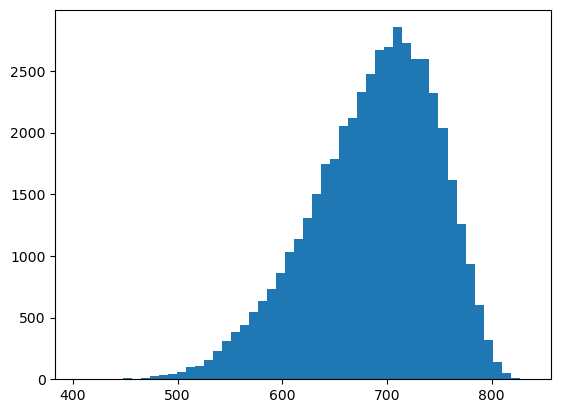

In [12]:
plt.hist(msa_energies[:, 0], weights=w_full_valid, bins=50)

In [15]:
msa_energies.shape

(208923, 3)

In [9]:
def analyze_smaller_model(train_end, test_start, test_end):
    TRAIN_END = train_end
    TEST_START = test_start
    TEST_END = test_end

    test_start_idx = valid_index(c, TEST_START)
    
    c2 = CouplingsModel(f"BLAT_ECOLX/model/BLAT_ECOLX_{TRAIN_END}.model_params")
    model_info(c2)
    w_small_valid = valid_weights_from_model(c2)

    msa_energies_small = energies_from_model(c2, processed_ecolx)
    
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 2, 1)
    plt.hist(msa_energies_small[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), density=True)
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title(f"Weighted Energy Distribution of MSA Data for the first {TRAIN_END} sequences from smaller model")

    plt.subplot(1, 2, 2)
    plt.hist(msa_energies[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), density=True)
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title(f"Weighted Energy Distribution of MSA Data for the first {TRAIN_END} sequences from original model")
    plt.show()

    c3 = CouplingsModel(f"BLAT_ECOLX/model/BLAT_ECOLX_{TEST_START}_{TEST_END}.model_params")
    w_test_valid = valid_weights_from_model(c3)
    plt.hist(msa_energies_small[test_start_idx:test_start_idx+len(w_test_valid), 0], 
        weights=w_test_valid, bins=50, range=(100, 500), label=f"{TEST_START}-{TEST_END}th sequences", alpha=0.7, density=True)
    plt.hist(msa_energies_small[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), 
        label=f"first {TRAIN_END} sequences (train)", alpha=0.6, density=True)
    plt.legend()
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title("Weighted Energy Distribution of MSA Data predicted by the small model")
    plt.show()

    w_test_valid = valid_weights_from_model(c3)
    plt.hist(msa_energies[test_start_idx:test_start_idx+len(w_test_valid), 0], 
        weights=w_test_valid, bins=50, label=f"{TEST_START}-{TEST_END}th sequences", alpha=0.7, density=True)
    plt.hist(msa_energies[:len(w_small_valid), 0], weights=w_small_valid, bins=50, 
        label=f"first {TRAIN_END} sequences (train)", alpha=0.6, density=True)
    plt.legend()
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title("Weighted Energy Distribution of MSA Data predicted by the full model")
    plt.show()

In [9]:
TRAIN_END = 10000
TEST_START = 100000
TEST_END = 150000

test_start_idx = valid_index(c, TEST_START)

c2 = CouplingsModel(f"BLAT_ECOLX/model/BLAT_ECOLX_{TRAIN_END}.model_params")
model_info(c2)
w_small_valid, _ = valid_weights_from_model(c2)

msa_energies_small = energies_from_model(c2, processed_ecolx)


Number of sites:  215
Number of invalid sequences:  65
Number of valid sequences:  9935


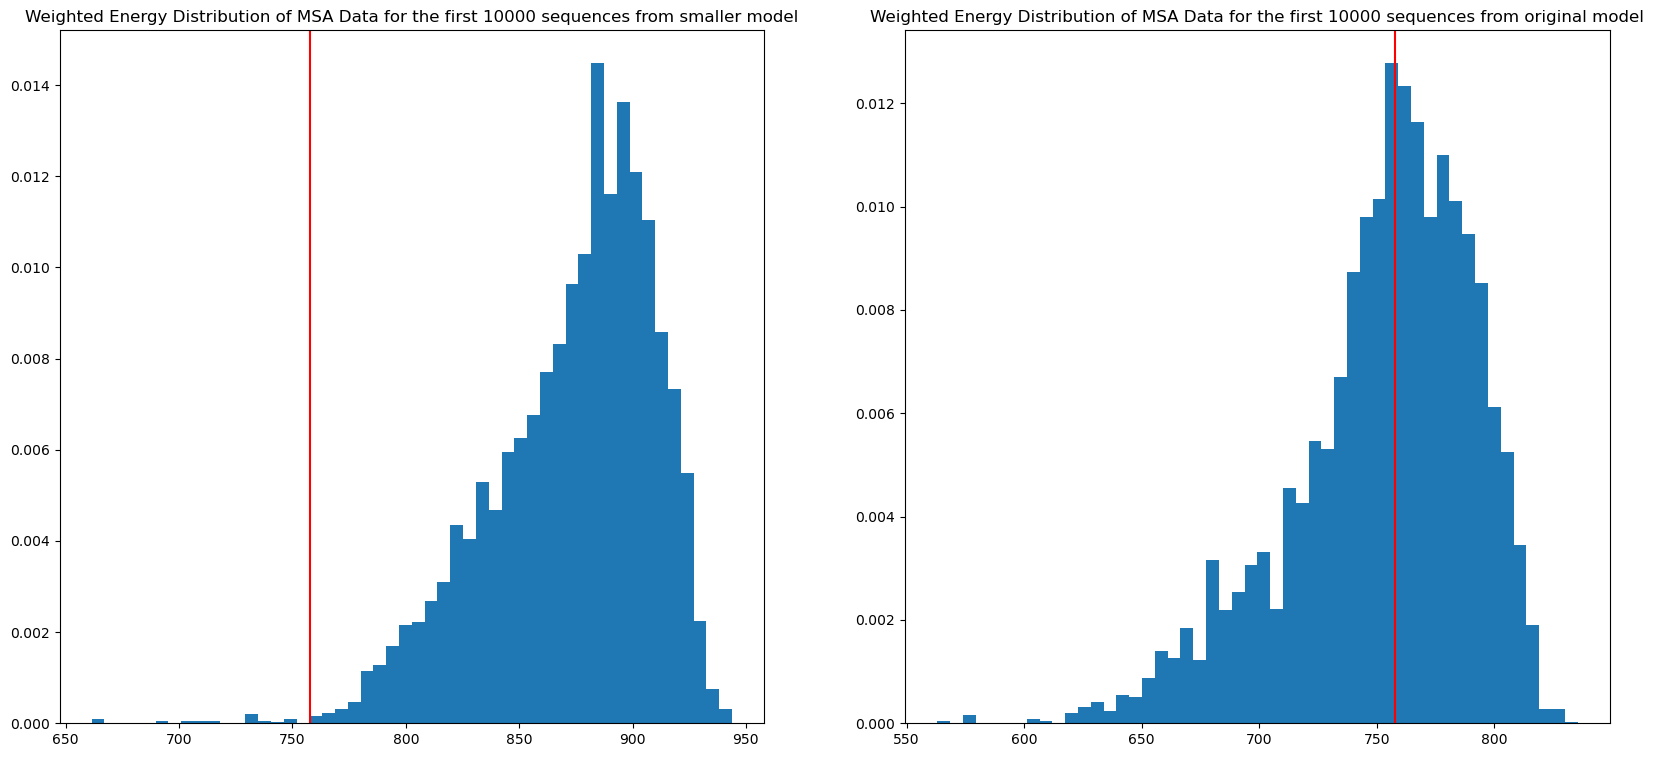

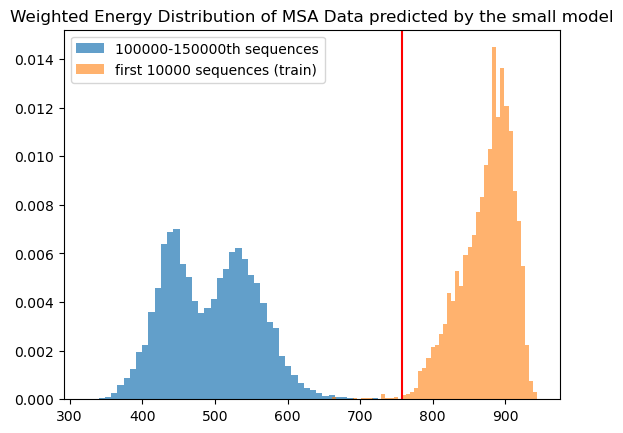

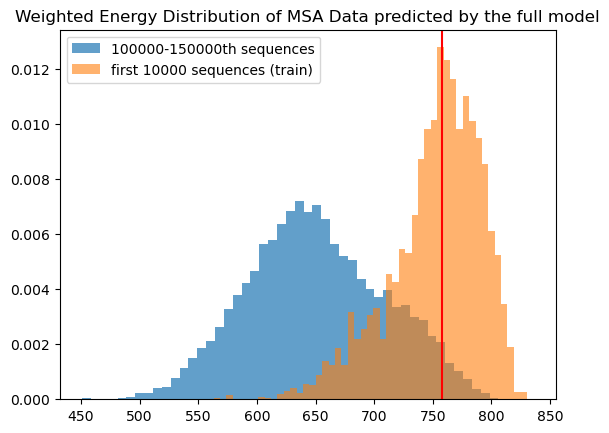

In [19]:

plt.figure(figsize=(20, 9))
plt.subplot(1, 2, 1)
plt.hist(msa_energies_small[:len(w_small_valid), 0], weights=w_small_valid, bins=50, density=True)
plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title(f"Weighted Energy Distribution of MSA Data for the first {TRAIN_END} sequences from smaller model")

plt.subplot(1, 2, 2)
plt.hist(msa_energies[:len(w_small_valid), 0], weights=w_small_valid, bins=50, density=True)
plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title(f"Weighted Energy Distribution of MSA Data for the first {TRAIN_END} sequences from original model")
plt.show()

c3 = CouplingsModel(f"BLAT_ECOLX/model/BLAT_ECOLX_{TEST_START}_{TEST_END}.model_params")
w_test_valid, _ = valid_weights_from_model(c3)
plt.hist(msa_energies_small[test_start_idx:test_start_idx+len(w_test_valid), 0], 
    weights=w_test_valid, bins=50, label=f"{TEST_START}-{TEST_END}th sequences", alpha=0.7, density=True)
plt.hist(msa_energies_small[:len(w_small_valid), 0], weights=w_small_valid, bins=50, 
    label=f"first {TRAIN_END} sequences (train)", alpha=0.6, density=True)
plt.legend()
plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title("Weighted Energy Distribution of MSA Data predicted by the small model")
plt.show()

w_test_valid, _ = valid_weights_from_model(c3)
plt.hist(msa_energies[test_start_idx:test_start_idx+len(w_test_valid), 0], 
    weights=w_test_valid, bins=50, label=f"{TEST_START}-{TEST_END}th sequences", alpha=0.7, density=True)
plt.hist(msa_energies[:len(w_small_valid), 0], weights=w_small_valid, bins=50, 
    label=f"first {TRAIN_END} sequences (train)", alpha=0.6, density=True)
plt.legend()
plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.title("Weighted Energy Distribution of MSA Data predicted by the full model")
plt.show()

In [18]:
len(w_small_valid)

9935